# Protein–Protein Binding Affinity Prediction with ESM-2 and DeepChem

**Author:** Suryavedha Pradhan \
**Date:** 01.02.26

## Introduction
Predicting the binding affinity changes ($\Delta\Delta G$) induced by mutations in protein-protein interactions (PPI) is a fundamental challenge in computational biology. Accurate predictions can accelerate drug discovery and antibody design.

In this tutorial, we implement a State-of-the-Art (SOTA) competitive pipeline using **Protein Language Models (PLMs)**. Unlike traditional physics-based methods (like FoldX) or pure sequence alignment methods, we leverage the contextual embeddings from **ESM-2** (Evolutionary Scale Modeling).

## Method Overview
We utilize a **Siamese Network** architecture with the following key components:
1.  **Encoder:** A frozen **ESM-2 (150M)** model to extract per-residue embeddings.
2.  **Aggregation:** A learned **Attention Pooling** layer. This allows the model to dynamically focus on residues important for binding (the interface) rather than treating all residues equally (Mean Pooling).
3.  **Interaction:** A projection head that explicitly models the difference between proteins using symmetric operators ($|A-B|$ and $A \odot B$).
4.  **Framework:** We use **PyTorch** for the model architecture and **DeepChem** for dataset management and metric evaluation.

## Dataset
We use a cleaned up version of the PPB-Affinity dataset, which contains experimental binding affinity in Pkd changes for mutations in protein complexes. We use a **GroupKFold** splitting strategy based on PDB IDs to ensure no data leakage occurs between the training and validation sets (Cold-Target Split).

## IMPORTS AND INITIAL SETUP


In [1]:
!pip install Bio esm deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 4

In [2]:
import os
import sys
import time
import json
import random
import pickle
from pathlib import Path
from datetime import datetime
from copy import deepcopy

# Standard data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

# Machine learning libraries
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

# PyTorch and Transformers / ESM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# HuggingFace transformers (fallback if fair-esm not installed)
from transformers import AutoModel, AutoTokenizer

import requests
from io import BytesIO
from zipfile import ZipFile
# Biopython (for fetching/reading PDBs and extracting sequences)
from Bio.PDB import PDBList, PDBParser, Polypeptide
from Bio import SeqIO

# DeepChem (used for dataset abstraction, metrics)
import deepchem as dc

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore', category=UserWarning)

print("🧬 Protein-Protein ΔΔG (ESM-2 embeddings + Attention Pooling)")
print("⚡ DeepChem + PyTorch training with GroupKFold cross-validation")
print("="*80)

def setup_reproducibility(seed=42):
    """Setup complete reproducibility."""
    print(f"🔒 Setting up reproducibility with seed {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✅ Reproducibility setup complete")

setup_reproducibility(42)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


🧬 Protein-Protein ΔΔG (ESM-2 embeddings + Attention Pooling)
⚡ DeepChem + PyTorch training with GroupKFold cross-validation
🔒 Setting up reproducibility with seed 42
✅ Reproducibility setup complete


## ESM-2 Embedding Extractor

This cell defines the `ESM2EmbeddingExtractor`. It supports caching, batch tokenization, and per-residue embedding extraction.

In [3]:
class ESM2EmbeddingExtractor:
    """
    Embedding extractor which tries to use HuggingFace ESM-2 model via AutoModel.
    Caches per-sequence embeddings to disk-friendly dictionary.
    """
    def __init__(self, model_name="facebook/esm2_t30_150M_UR50D", max_seq_len=1024, batch_size=16, device="auto", pool_strategy="per_residue"):
        self.model_name = model_name
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.pool_strategy = pool_strategy
        if device == "auto":
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device(device)

        print(f"🔧 Initializing ESM2EmbeddingExtractor on {self.device} with model {model_name}")
        self.dtype = torch.float16 if self.device.type == 'cuda' else torch.float32

        try:
            self.model = AutoModel.from_pretrained(self.model_name, trust_remote_code=True)
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, do_lower_case=False)
            if getattr(self.tokenizer, "pad_token", None) is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.padding_side = "left"
            self.model.to(self.device)
            self.model.eval()
            # REMOVED: torch.set_grad_enabled(False) -- This was breaking the training loop
            print("✅ Loaded model via transformers.AutoModel")
        except Exception as e:
            print("⚠️ Warning: Could not load model via transformers.AutoModel:", e)
            raise

        try:
            self.embedding_size = self.model.config.hidden_size
        except Exception:
            self.embedding_size = getattr(self.model.config, "n_embd", None) or 1024

        print(f"   Embedding size (model hidden dim): {self.embedding_size}")
        self.embedding_cache = {}

    def _tokenize_batch(self, sequences):
        return self.tokenizer(sequences,
                              padding=True,
                              truncation=True,
                              max_length=self.max_seq_len,
                              return_tensors="pt",
                              return_attention_mask=True)

    def compute_per_residue_embeddings_batch(self, sequences):
        if not sequences:
            return []

        inputs = self._tokenize_batch(sequences)
        model_inputs = {}
        for k in ["input_ids", "attention_mask", "token_type_ids"]:
            if k in inputs:
                model_inputs[k] = inputs[k].to(self.device)

        # We use a context manager here instead of a global switch
        with torch.no_grad():
            outputs = self.model(**model_inputs, output_hidden_states=True)
            if hasattr(outputs, "last_hidden_state"):
                last_hidden = outputs.last_hidden_state
            else:
                last_hidden = outputs.hidden_states[-1]
            last_hidden = last_hidden.cpu()

        attention_masks = inputs.get("attention_mask", None)
        batch_embeddings = []
        for i in range(last_hidden.size(0)):
            if attention_masks is not None:
                mask = attention_masks[i].cpu().bool()
                seq_embeddings = last_hidden[i][mask]
            else:
                seq_embeddings = last_hidden[i]
            batch_embeddings.append(seq_embeddings)
        return batch_embeddings

    def get_embeddings(self, sequences, use_cache=True, show_progress=True):
        if isinstance(sequences, str):
            sequences = [sequences]

        to_compute = []
        results = {}
        for i, seq in enumerate(sequences):
            if use_cache and seq in self.embedding_cache:
                results[seq] = self.embedding_cache[seq]
            else:
                to_compute.append(seq)

        if to_compute:
            if show_progress:
                print(f"🧮 Computing {len(to_compute)} new ESM embeddings...")

            # Using tqdm
            pbar = tqdm(range(0, len(to_compute), self.batch_size), desc="ESM2 embed", disable=not show_progress)
            for start in pbar:
                end = min(start + self.batch_size, len(to_compute))
                batch_seqs = to_compute[start:end]
                batch_embeddings = self.compute_per_residue_embeddings_batch(batch_seqs)
                for seq, emb in zip(batch_seqs, batch_embeddings):
                    emb_cpu = emb.clone().detach().float()
                    self.embedding_cache[seq] = emb_cpu
                    results[seq] = emb_cpu
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        for seq in sequences:
            if seq not in results:
                results[seq] = torch.empty((0, self.embedding_size), dtype=torch.float32)
        return results

    def save_cache(self, cache_path):
        print(f"💾 Saving embedding cache to {cache_path}")
        serializable_cache = {k: v.numpy() for k, v in self.embedding_cache.items()}
        with open(cache_path, "wb") as f:
            pickle.dump(serializable_cache, f)
        print(f"✅ Saved {len(serializable_cache)} cached embeddings.")

    def load_cache(self, cache_path):
        if os.path.exists(cache_path):
            print(f"📥 Loading embedding cache from {cache_path}")
            try:
                with open(cache_path, "rb") as f:
                    data = pickle.load(f)
                self.embedding_cache = {k: torch.tensor(v, dtype=torch.float32) for k, v in data.items()}
                print(f"✅ Loaded {len(self.embedding_cache)} cached embeddings.")
                return True
            except Exception as e:
                print(f"⚠️ Could not load cache file: {e}. Creating new cache.")
                self.embedding_cache = {}
                return False
        return False

## Data Preparation

The dataset consists of pairs of protein sequences (Wildtype and Mutant, or Receptor and Ligand) and their associated binding affinity ($\Delta G$ or $\Delta\Delta G$).

To ensure rigorous evaluation, we group data points by their `complex_id` (PDB ID). This prevents the model from "memorizing" a specific protein interface during training.

> **Note:** If you are running this tutorial locally and do not have the dataset, the cell below will automatically download the dataset for you.

In [4]:
# --- CONFIGURATION ---
DATASET_FILENAME = 'binding_affinity_dataset.csv'
# REPLACE THIS URL WITH YOUR ACTUAL GITHUB RAW LINK
DATASET_URL = 'https://raw.githubusercontent.com/Suryavedha99/Binding-Affinity-Dataset/refs/heads/main/binding_affinity_dataset.csv'

if not os.path.exists(DATASET_FILENAME):
    print(f"📦 Dataset not found locally. Downloading from GitHub...")
    try:
        response = requests.get(DATASET_URL)
        response.raise_for_status() # Check for HTTP errors

        with open(DATASET_FILENAME, 'wb') as f:
            f.write(response.content)
        print(f"✅ Download complete: {DATASET_FILENAME}")

    except requests.exceptions.RequestException as e:
        print(f"❌ Error downloading dataset: {e}")
        print("Please check your internet connection or the URL.")
else:
    print(f"✅ Dataset found locally: {DATASET_FILENAME}")

📦 Dataset not found locally. Downloading from GitHub...
✅ Download complete: binding_affinity_dataset.csv


## Dataset loading

This cell reads `binding_affinity_dataset.csv` using the configured column names and renames to the canonical names used in the notebook (`seqA`, `seqB`, `ddg`, `complex_id`).

In [5]:
print("\n" + "="*80)
print("... 3. LOADING DATA...")

# --- IMPORTANT: CONFIGURE YOUR COLUMN NAMES HERE --- #
# Change these if your CSV uses different names
protein1_col = 'proteina'    # Column name for the first protein sequence
protein2_col = 'proteinb'  # Column name for the second protein sequence
target_col = 'Pkd'           # Column name for the binding affinity value (e.g., ddG)
pdb_col_raw = 'PDB'        # Column name to use for grouping (complex id)
# --------------------------------------------------- #

# Load the dataset
try:
    df_raw = pd.read_csv('binding_affinity_dataset.csv')
    print(f"Successfully loaded binding_affinity_dataset.csv with {len(df_raw)} rows.")

    # Create the final dataframe with the expected column names
    df = df_raw[[protein1_col, protein2_col, target_col, pdb_col_raw]].copy()
    df.rename(columns={
        protein1_col: 'proteina',
        protein2_col: 'proteinb',
        target_col: 'Pkd',
        pdb_col_raw: 'PDB'
    }, inplace=True)

    # --- Data Validation ---
    print("\n--- Initial Data Check ---")
    print("Data Head:")
    print(df.head())

    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values)

    if missing_values.sum() > 0:
        print(f"\nWarning: Found {missing_values.sum()} total missing values. Dropping rows with NaNs.")
        df.dropna(subset=['proteina', 'proteinb', 'Pkd', 'PDB'], inplace=True)
        print(f"Dataset now has {len(df)} rows after cleaning.")

    # Ensure data types are correct
    df['proteina'] = df['proteina'].astype(str)
    df['proteinb'] = df['proteinb'].astype(str)
    df['Pkd'] = pd.to_numeric(df['Pkd'], errors='coerce') # Converts non-numbers to NaN
    df['PDB'] = df['PDB'].astype(str)
    df.dropna(subset=['Pkd'], inplace=True) # Drop rows where Y could not be converted to a number

    # --- BACKWARDS-COMPATIBILITY NAMES FOR THE REST OF THE PIPELINE ---
    # The rest of your notebook expects columns named: seqA, seqB, ddg, complex_id
    df = df.rename(columns={
        'proteina': 'seqA',
        'proteinb': 'seqB',
        'Pkd': 'ddg',
        'PDB': 'complex_id'
    })

    print(f"\n✅ Data is loaded and cleaned. Final dataset size: {len(df)} samples.")
    print("Data Info:")
    df.info()

except FileNotFoundError:
    print("❌ ERROR: 'binding_affinity_dataset.csv' not found. Please make sure it's in the same directory as the notebook.")
    # Create an empty dataframe to prevent the rest of the script from crashing
    df = pd.DataFrame(columns=['seqA', 'seqB', 'ddg', 'complex_id'])
except KeyError as e:
    print(f"❌ ERROR: Column {e} not found in 'binding_affinity_dataset'. Please check the column names in the 'CONFIGURE' section above.")
    df = pd.DataFrame(columns=['seqA', 'seqB', 'ddg', 'complex_id'])

# Final DF check (keeps the same downstream print)
print("Final dataset preview:")
print(df.head())
print(f"Total samples: {len(df)}")


... 3. LOADING DATA...
Successfully loaded binding_affinity_dataset.csv with 12019 rows.

--- Initial Data Check ---
Data Head:
                                            proteina  \
0  FPTIPLSRLFDNAMLRAHRLHQLAFDTYQEFEEAYIPKEQKYSFLQ...   
1  SLDIQSLDIQCEELSDARWAELLPLLQQCQVVRLDDCGLTEARCKD...   
2  CGVPAIQPVLSGLIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLIN...   
3  DIKMTQSPSSMYASLGERVTITCKASQDIRKYLNWYQQKPWKSPKT...   
4  MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...   

                                            proteinb        Pkd   PDB  
0  PKFTKCRSPERETFSCHWTLGPIQLFYTRRNTQEWTQEWKECPDYV...   9.045757  1A22  
1  QDNSRYTHFLTQHYDAKPQGRDDRYCESIMRRRGLTSPCKDINTFI...  15.301030  1A4Y  
2  KSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDLRYNRVR...  11.826814  1ACB  
3  TNTVAAYNLTWKSTNFKTILEWEPKPVNQVYTVQISTKSGDWKSKC...   8.468521  1AHW  
4  PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...   4.920819  1AK4  

Missing values per column:
proteina    0
proteinb    0
Pkd         0
PDB         0
dtype: int64

✅ Da

## Feature Extraction with ESM-2

We use the **ESM-2 (t30_150M_UR50D)** model from Meta Research. ESM-2 is a transformer protein language model trained on millions of protein sequences. It captures rich evolutionary and structural information in its internal states.

**Why freeze the model?**
Fine-tuning PLMs requires significant GPU memory. By freezing the ESM-2 weights and pre-computing embeddings, we allow this pipeline to run efficiently on standard GPUs (or even CPUs for inference) while still benefiting from the PLM's deep knowledge.

In [6]:
print("\n" + "="*80)
print("... 4. MANAGING ESM-2 EMBEDDINGS CACHE ...")

CACHE_FILE = "esm2_embeddings_cache.pkl"
esm_model_name = "facebook/esm2_t30_150M_UR50D"  # change if you prefer a different ESM-2 variant

extractor = ESM2EmbeddingExtractor(model_name=esm_model_name, batch_size=16)
cache_loaded = extractor.load_cache(CACHE_FILE)

# collect unique sequences
unique_sequences = pd.concat([df["seqA"], df["seqB"]]).unique().tolist()
print(f"Found {len(unique_sequences)} unique sequences in dataset.")

# Compute only missing embeddings
missing_sequences = [s for s in unique_sequences if s not in extractor.embedding_cache]
if cache_loaded and not missing_sequences:
    print("✅ All embeddings loaded from cache.")
else:
    if cache_loaded:
        print(f"⚠️ Cache missing {len(missing_sequences)} sequences; computing them now.")
    else:
        print("📦 No cache or empty cache found; computing embeddings for all sequences.")
    # compute in batches (get_embeddings caches them)
    _ = extractor.get_embeddings(missing_sequences if missing_sequences else unique_sequences, show_progress=True)
    extractor.save_cache(CACHE_FILE)

EMBEDDING_CACHE = extractor.embedding_cache  # seq -> tensor (L, d)
EMBEDDING_DIM = extractor.embedding_size
print(f"✅ Embedding cache ready with {len(EMBEDDING_CACHE)} sequences. Embedding dim: {EMBEDDING_DIM}")


... 4. MANAGING ESM-2 EMBEDDINGS CACHE ...
🔧 Initializing ESM2EmbeddingExtractor on cuda with model facebook/esm2_t30_150M_UR50D


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

✅ Loaded model via transformers.AutoModel
   Embedding size (model hidden dim): 640
Found 7045 unique sequences in dataset.
📦 No cache or empty cache found; computing embeddings for all sequences.
🧮 Computing 7045 new ESM embeddings...


ESM2 embed:   0%|          | 0/441 [00:00<?, ?it/s]

💾 Saving embedding cache to esm2_embeddings_cache.pkl
✅ Saved 7045 cached embeddings.
✅ Embedding cache ready with 7045 sequences. Embedding dim: 640


## A DeepChem dataset abstraction

This creates a minimal `dc.data.NumpyDataset` for bookkeeping and metrics compatibility.

In [ ]:
print("\n" + "="*80)
print("... 4.A: Creating a minimal DeepChem NumpyDataset for bookkeeping and metrics ...")

# We will create a minimal NumpyDataset whose X are integer indices (so it's simple to map to rows)
# This allows using DeepChem metrics, and (optionally) save to DiskDataset if desired.

if len(df) == 0:
    print("⚠️ WARNING: df is empty. Skipping DeepChem dataset creation.")
else:
    X_indices = np.arange(len(df))[:, None]  # shape (N, 1) - simple index feature
    y_values = df['ddg'].values.reshape(-1, 1)  # shape (N, 1)

    # Create a DeepChem NumpyDataset (in-memory)
    dc_dataset = dc.data.NumpyDataset(X_indices, y_values)
    print(f"✅ Created DeepChem NumpyDataset with {len(dc_dataset)} samples.")

    # Optional: save as DiskDataset by writing arrays to disk (this is just an example)
    DC_DISKDIR = "dc_skempi_dataset"
    try:
        # DiskDataset expects a directory; use DiskDataset constructor to save
        if not os.path.exists(DC_DISKDIR):
            os.makedirs(DC_DISKDIR, exist_ok=True)
        # Save np arrays manually; this is optional and only for convenience.
        np.save(os.path.join(DC_DISKDIR, "X.npy"), X_indices)
        np.save(os.path.join(DC_DISKDIR, "y.npy"), y_values)
        print(f"Saved arrays to {DC_DISKDIR}/ for potential DiskDataset loading later.")
    except Exception as e:
        print("⚠️ Could not save DeepChem disk files:", e)

dc_rmse_metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
dc_pearson_metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)


... 4.A: Creating a minimal DeepChem NumpyDataset for bookkeeping and metrics ...
✅ Created DeepChem NumpyDataset with 12019 samples.
Saved arrays to dc_skempi_dataset/ for potential DiskDataset loading later.


## Model Architecture: Attention and Interaction

### 1. Learned Attention Pooling
Protein binding sites typically involve only a small fraction of the total residues. Standard **Mean Pooling** averages the signal of the binding site with the noise of the rest of the protein.

Instead, we use **Attention Pooling**. The model learns a weight $\alpha_i$ for every residue $i$. The final representation $h$ is a weighted sum:
$$ h = \sum \alpha_i \cdot E_i $$
This allows the network to "zoom in" on the interface residues that drive binding affinity.

### 2. Siamese Interaction Features
To predict the relationship between two protein sequences ($A$ and $B$), we need more than just their individual embeddings. We explicitly construct an interaction vector $z$ using operations that capture both their similarities and their differences:
$$ z = \text{Concat}(h_A, h_B, |h_A - h_B|, h_A \odot h_B) $$

*   $|h_A - h_B|$: Captures the **difference** (crucial for predicting mutation effects).
*   $h_A \odot h_B$: Captures the **element-wise interaction** (compatibility).

In [8]:
print("\n" + "="*80)
print("... 5. DEFINING ATTENTION POOLING MODEL & DATASET ...")

class AttentionPooling(nn.Module):
    """
    Learned attention pooling over residue embeddings.
    Input: (B, L, d) with mask (B, L) boolean or None
    Output: (B, d)
    """
    def __init__(self, input_dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or input_dim // 4
        self.attn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, mask=None):
        # x: (B, L, d)
        scores = self.attn(x).squeeze(-1)  # (B, L)
        if mask is not None:
            scores = scores.masked_fill(~mask, float("-inf"))
        weights = torch.softmax(scores, dim=-1)  # (B, L)
        weights = weights.unsqueeze(-1)  # (B, L, 1)
        pooled = torch.sum(weights * x, dim=1)  # (B, d)
        return pooled, weights.squeeze(-1)  # return attention weights for interpretability

class PPiAttentionModel(nn.Module):
    """
    Full model:
      - Accepts per-residue embeddings for seqA and seqB
      - Attention pooling -> hA, hB (d)
      - Interaction features: concat(hA, hB, |hA-hB|, hA * hB)
      - Regression MLP -> scalar ΔΔG
    """
    def __init__(self, embedding_dim, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.poolA = AttentionPooling(embedding_dim, hidden_dim=embedding_dim//4)
        self.poolB = AttentionPooling(embedding_dim, hidden_dim=embedding_dim//4)

        feat_dim = embedding_dim * 4  # hA, hB, |hA-hB|, hA* hB
        self.regressor = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, seqA_embeddings, seqA_mask, seqB_embeddings, seqB_mask):
        # seq*_embeddings: (B, L, d) ; masks: (B, L) boolean
        hA, attnA = self.poolA(seqA_embeddings, seqA_mask)  # (B, d)
        hB, attnB = self.poolB(seqB_embeddings, seqB_mask)  # (B, d)

        interaction = torch.cat([hA, hB, torch.abs(hA - hB), hA * hB], dim=-1)  # (B, feat_dim)
        out = self.regressor(interaction).squeeze(-1)  # (B,)
        return out, {"attnA": attnA, "attnB": attnB}

class PPIDataset(Dataset):
    """
    Dataset that returns tensors ready for the model:
      - seqA_embeddings_padded: (Lmax, d)
      - seqA_mask: (Lmax) boolean
      - seqB_embeddings_padded, seqB_mask
      - target ddg (float)
    This dataset pads sequences per-batch in collate_fn (so here we return per-sample embeddings).
    """
    def __init__(self, dataframe, embedding_cache):
        self.df = dataframe.reset_index(drop=True)
        self.cache = embedding_cache

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seqA = row["seqA"]
        seqB = row["seqB"]
        y = float(row["ddg"])

        embA = self.cache.get(seqA, torch.empty((0, EMBEDDING_DIM)))
        embB = self.cache.get(seqB, torch.empty((0, EMBEDDING_DIM)))
        return {"embA": embA, "embB": embB, "y": y}

def collate_ppi(batch):
    """
    Pads per-residue embeddings to max length in batch.
    Returns:
      seqA_embeddings: (B, LmaxA, d)
      seqA_mask: (B, LmaxA) boolean
      seqB_embeddings: (B, LmaxB, d)
      seqB_mask: (B, LmaxB)
      targets: (B,)
    """
    embAs = [item["embA"] for item in batch]
    embBs = [item["embB"] for item in batch]
    ys = torch.tensor([item["y"] for item in batch], dtype=torch.float32)

    # pad A
    lenA = [e.size(0) for e in embAs]
    maxA = max(1, max(lenA))
    paddedA = torch.zeros((len(embAs), maxA, EMBEDDING_DIM), dtype=torch.float32)
    maskA = torch.zeros((len(embAs), maxA), dtype=torch.bool)
    for i, e in enumerate(embAs):
        L = e.size(0)
        if L == 0:
            # leave zero padding
            continue
        paddedA[i, :L, :] = e
        maskA[i, :L] = True

    # pad B
    lenB = [e.size(0) for e in embBs]
    maxB = max(1, max(lenB))
    paddedB = torch.zeros((len(embBs), maxB, EMBEDDING_DIM), dtype=torch.float32)
    maskB = torch.zeros((len(embBs), maxB), dtype=torch.bool)
    for i, e in enumerate(embBs):
        L = e.size(0)
        if L == 0:
            continue
        paddedB[i, :L, :] = e
        maskB[i, :L] = True

    return {
        "seqA_emb": paddedA,
        "seqA_mask": maskA,
        "seqB_emb": paddedB,
        "seqB_mask": maskB,
        "y": ys
    }


... 5. DEFINING ATTENTION POOLING MODEL & DATASET ...


## Metrics and evaluation helpers

This cell contains the concordance index and the simple evaluation loop used during CV.

In [9]:
print("\n" + "="*80)
print("... 6. DEFINING METRICS AND EVALUATION ...")

def concordance_index(y_true, y_pred):
    """Calculate concordance index."""
    try:
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        n = len(y_true)
        if n < 2: return 1.0
        concordant = 0
        discordant = 0
        tied_pred = 0
        for i in range(n):
            for j in range(i + 1, n):
                if y_true[i] == y_true[j]:
                    continue
                if y_pred[i] == y_pred[j]:
                    tied_pred += 1
                    continue
                if (y_pred[i] > y_pred[j] and y_true[i] > y_true[j]) or \
                   (y_pred[i] < y_pred[j] and y_true[i] < y_true[j]):
                    concordant += 1
                else:
                    discordant += 1
        if (concordant + discordant + tied_pred) == 0:
            return 1.0
        ci = (concordant + 0.5 * tied_pred) / (concordant + discordant + tied_pred)
        return ci
    except Exception:
        return np.nan

def evaluate_model_simple(model, data_loader, device):
    """
    Evaluate the model with a simple PyTorch loop.
    Returns metrics dict and arrays of y_true, y_pred.
    """
    model.eval()
    all_y = []
    all_pred = []
    with torch.no_grad():
        for batch in data_loader:
            seqA_emb = batch["seqA_emb"].to(device)
            seqA_mask = batch["seqA_mask"].to(device)
            seqB_emb = batch["seqB_emb"].to(device)
            seqB_mask = batch["seqB_mask"].to(device)
            y = batch["y"].to(device)

            preds, _ = model(seqA_emb, seqA_mask, seqB_emb, seqB_mask)
            preds = preds.detach().cpu().numpy()
            all_pred.extend(preds.tolist())
            all_y.extend(y.cpu().numpy().tolist())

    labels = np.array(all_y)
    preds = np.array(all_pred)
    mask = ~np.isnan(labels) & ~np.isnan(preds)
    labels, preds = labels[mask], preds[mask]
    if len(labels) < 2:
        metrics = {"rmse": np.nan, "pearson": np.nan, "spearman": np.nan, "ci": np.nan}
    else:
        metrics = {
            "rmse": np.sqrt(mean_squared_error(labels, preds)),
            "pearson": pearsonr(labels, preds)[0],
            "spearman": spearmanr(labels, preds)[0],
            "ci": concordance_index(labels, preds)
        }
    return metrics, labels, preds


... 6. DEFINING METRICS AND EVALUATION ...


## Experiment configuration

Hyperparameters and CV strategy are defined here; change as needed before running.

In [10]:
print("\n" + "="*80)
print("... 6.A: CONFIGURING THE EXPERIMENT ...")

# CV and training hyperparameters
CV_STRATEGY = "GroupKFold"  # ensure splits grouped by 'complex_id' column
N_SPLITS = 10
EPOCHS = 100
BATCH_SIZE = 8
EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_MIN_DELTA = 1e-4
LEARNING_RATE = 1e-4
HIDDEN_DIM = 512
DROPOUT = 0.1

print(f"✅ Configuration: CV={CV_STRATEGY}, N_SPLITS={N_SPLITS}, EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}")


... 6.A: CONFIGURING THE EXPERIMENT ...
✅ Configuration: CV=GroupKFold, N_SPLITS=10, EPOCHS=100, BATCH_SIZE=8


## GroupK-Fold splitting & plotting helpers

Utility to split by `complex_id` and to plot results per fold.

In [ ]:
print("\n" + "="*80)
print("... 6.B: DEFINING GROUPK-FOLD SPLITTING LOGIC ...")

def get_group_splits(df, n_splits):
    groups = df["complex_id"].values
    gkf = GroupKFold(n_splits=n_splits)
    for train_index, test_index in gkf.split(df, groups=groups):
        yield train_index, test_index

print("✅ GroupKFold split generator ready.")

def plot_regression(y_true, y_pred, metrics, title):

    plt.figure(figsize=(5.5, 5.5))

    # Scatter
    plt.scatter(
        y_true,
        y_pred,
        s=18,
        alpha=0.65,
        color="#4C72B0",
        marker="x"
    )


    # Identity line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        linewidth=1
    )

    # Metrics (top-left, subtle)
    metrics_text = (
        f"RMSE = {metrics['rmse']:.3f}\n"
        f"Pearson r = {metrics['pearson']:.3f}\n"
        f"Spearman ρ = {metrics['spearman']:.3f}\n"
        f"CI = {metrics['ci']:.3f}"
    )
    plt.text(
        0.04, 0.96,
        metrics_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        va="top"
    )

    # Labels
    plt.xlabel("Actual ΔΔG")
    plt.ylabel("Predicted ΔΔG")
    plt.title(title, fontsize=13)

    # Clean look
    plt.grid(False)
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

print("✅ Regression plotting function is ready.")


... 6.B: DEFINING GROUPK-FOLD SPLITTING LOGIC ...
✅ GroupKFold split generator ready.
✅ Regression plotting function is ready.


## Cross-validation training loop

This cell runs the GroupKFold CV, trains per-fold, saves best fold models, and computes DeepChem metrics per-fold.


... 7. STARTING GROUPK-FOLD CROSS-VALIDATION ...
Device: cuda
Prepared 10 folds.

===== FOLD 1/10 =====
Train samples: 10817 | Val samples: 1202


Fold 1 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.6550 | Best RMSE: inf | Patience: 0/10


Fold 1 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.5802 | Best RMSE: 1.6550 | Patience: 0/10


Fold 1 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.4988 | Best RMSE: 1.5802 | Patience: 0/10


Fold 1 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.4887 | Best RMSE: 1.4988 | Patience: 0/10


Fold 1 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.4216 | Best RMSE: 1.4887 | Patience: 0/10


Fold 1 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.4817 | Best RMSE: 1.4216 | Patience: 0/10


Fold 1 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.4560 | Best RMSE: 1.4216 | Patience: 1/10


Fold 1 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.4265 | Best RMSE: 1.4216 | Patience: 2/10


Fold 1 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.5242 | Best RMSE: 1.4216 | Patience: 3/10


Fold 1 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.4151 | Best RMSE: 1.4216 | Patience: 4/10


Fold 1 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.4375 | Best RMSE: 1.4151 | Patience: 0/10


Fold 1 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.4849 | Best RMSE: 1.4151 | Patience: 1/10


Fold 1 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.4488 | Best RMSE: 1.4151 | Patience: 2/10


Fold 1 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.4802 | Best RMSE: 1.4151 | Patience: 3/10


Fold 1 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.3887 | Best RMSE: 1.4151 | Patience: 4/10


Fold 1 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.4405 | Best RMSE: 1.3887 | Patience: 0/10


Fold 1 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.4641 | Best RMSE: 1.3887 | Patience: 1/10


Fold 1 Epoch 18/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 18 | Val RMSE: 1.4435 | Best RMSE: 1.3887 | Patience: 2/10


Fold 1 Epoch 19/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 19 | Val RMSE: 1.5467 | Best RMSE: 1.3887 | Patience: 3/10


Fold 1 Epoch 20/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 20 | Val RMSE: 1.4610 | Best RMSE: 1.3887 | Patience: 4/10


Fold 1 Epoch 21/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 21 | Val RMSE: 1.4130 | Best RMSE: 1.3887 | Patience: 5/10


Fold 1 Epoch 22/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 22 | Val RMSE: 1.4282 | Best RMSE: 1.3887 | Patience: 6/10


Fold 1 Epoch 23/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 23 | Val RMSE: 1.5137 | Best RMSE: 1.3887 | Patience: 7/10


Fold 1 Epoch 24/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 24 | Val RMSE: 1.4754 | Best RMSE: 1.3887 | Patience: 8/10


Fold 1 Epoch 25/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 25 | Val RMSE: 1.4469 | Best RMSE: 1.3887 | Patience: 9/10
⏹️ Early stopping at epoch 25
Fold 1 Metrics: RMSE=1.3887, Pearson=0.7671, Spearman=0.7069, CI=0.7599
Saved fold 1 best model to best_model_fold1.pth


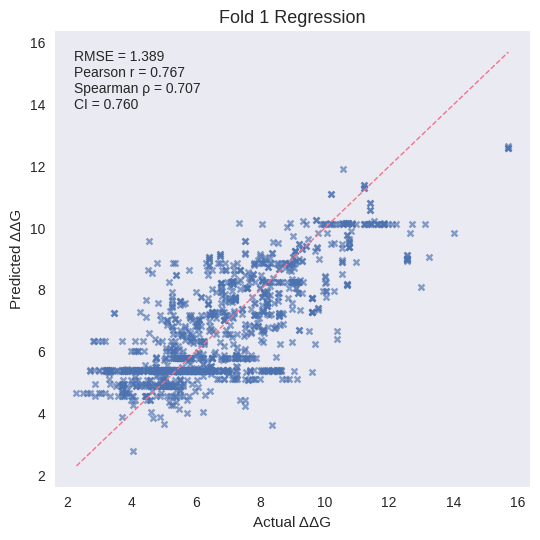

(deepchem metrics) RMSE: 1.3887, Pearson: 0.5884

===== FOLD 2/10 =====
Train samples: 10817 | Val samples: 1202


Fold 2 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.6485 | Best RMSE: inf | Patience: 0/10


Fold 2 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.4668 | Best RMSE: 1.6485 | Patience: 0/10


Fold 2 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.6208 | Best RMSE: 1.4668 | Patience: 0/10


Fold 2 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.4851 | Best RMSE: 1.4668 | Patience: 1/10


Fold 2 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.4411 | Best RMSE: 1.4668 | Patience: 2/10


Fold 2 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.4408 | Best RMSE: 1.4411 | Patience: 0/10


Fold 2 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.4359 | Best RMSE: 1.4408 | Patience: 0/10


Fold 2 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.4710 | Best RMSE: 1.4359 | Patience: 0/10


Fold 2 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.4401 | Best RMSE: 1.4359 | Patience: 1/10


Fold 2 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.4706 | Best RMSE: 1.4359 | Patience: 2/10


Fold 2 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.4572 | Best RMSE: 1.4359 | Patience: 3/10


Fold 2 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.4630 | Best RMSE: 1.4359 | Patience: 4/10


Fold 2 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.4762 | Best RMSE: 1.4359 | Patience: 5/10


Fold 2 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.4679 | Best RMSE: 1.4359 | Patience: 6/10


Fold 2 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.4539 | Best RMSE: 1.4359 | Patience: 7/10


Fold 2 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.4758 | Best RMSE: 1.4359 | Patience: 8/10


Fold 2 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.4671 | Best RMSE: 1.4359 | Patience: 9/10
⏹️ Early stopping at epoch 17
Fold 2 Metrics: RMSE=1.4359, Pearson=0.7198, Spearman=0.7223, CI=0.7652
Saved fold 2 best model to best_model_fold2.pth


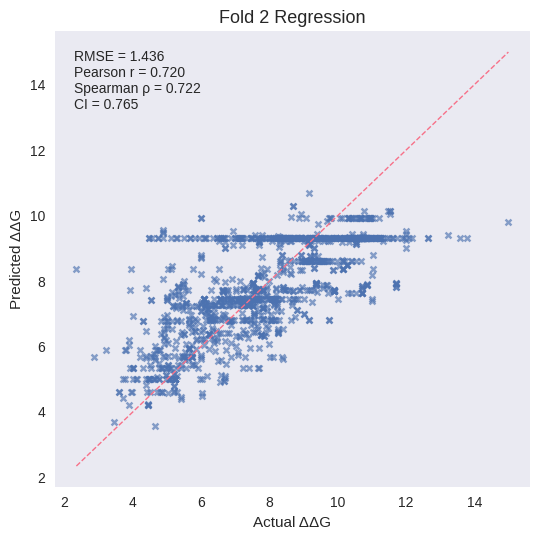

(deepchem metrics) RMSE: 1.4359, Pearson: 0.5182

===== FOLD 3/10 =====
Train samples: 10817 | Val samples: 1202


Fold 3 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.8088 | Best RMSE: inf | Patience: 0/10


Fold 3 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.7304 | Best RMSE: 1.8088 | Patience: 0/10


Fold 3 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.6946 | Best RMSE: 1.7304 | Patience: 0/10


Fold 3 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.6904 | Best RMSE: 1.6946 | Patience: 0/10


Fold 3 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.7472 | Best RMSE: 1.6904 | Patience: 0/10


Fold 3 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.7072 | Best RMSE: 1.6904 | Patience: 1/10


Fold 3 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.6857 | Best RMSE: 1.6904 | Patience: 2/10


Fold 3 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.7294 | Best RMSE: 1.6857 | Patience: 0/10


Fold 3 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.6962 | Best RMSE: 1.6857 | Patience: 1/10


Fold 3 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.6773 | Best RMSE: 1.6857 | Patience: 2/10


Fold 3 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.7056 | Best RMSE: 1.6773 | Patience: 0/10


Fold 3 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.6848 | Best RMSE: 1.6773 | Patience: 1/10


Fold 3 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.8538 | Best RMSE: 1.6773 | Patience: 2/10


Fold 3 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.7473 | Best RMSE: 1.6773 | Patience: 3/10


Fold 3 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.7715 | Best RMSE: 1.6773 | Patience: 4/10


Fold 3 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.7074 | Best RMSE: 1.6773 | Patience: 5/10


Fold 3 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.7391 | Best RMSE: 1.6773 | Patience: 6/10


Fold 3 Epoch 18/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 18 | Val RMSE: 1.7432 | Best RMSE: 1.6773 | Patience: 7/10


Fold 3 Epoch 19/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 19 | Val RMSE: 1.8015 | Best RMSE: 1.6773 | Patience: 8/10


Fold 3 Epoch 20/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 20 | Val RMSE: 1.7396 | Best RMSE: 1.6773 | Patience: 9/10
⏹️ Early stopping at epoch 20
Fold 3 Metrics: RMSE=1.6773, Pearson=0.5854, Spearman=0.5970, CI=0.7060
Saved fold 3 best model to best_model_fold3.pth


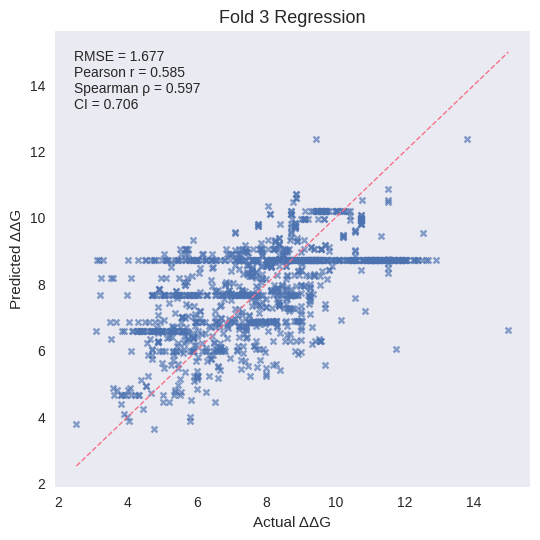

(deepchem metrics) RMSE: 1.6773, Pearson: 0.3427

===== FOLD 4/10 =====
Train samples: 10817 | Val samples: 1202


Fold 4 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.6476 | Best RMSE: inf | Patience: 0/10


Fold 4 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.6867 | Best RMSE: 1.6476 | Patience: 0/10


Fold 4 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.6640 | Best RMSE: 1.6476 | Patience: 1/10


Fold 4 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.9848 | Best RMSE: 1.6476 | Patience: 2/10


Fold 4 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.8397 | Best RMSE: 1.6476 | Patience: 3/10


Fold 4 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.6320 | Best RMSE: 1.6476 | Patience: 4/10


Fold 4 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.6966 | Best RMSE: 1.6320 | Patience: 0/10


Fold 4 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.7129 | Best RMSE: 1.6320 | Patience: 1/10


Fold 4 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.7669 | Best RMSE: 1.6320 | Patience: 2/10


Fold 4 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.6587 | Best RMSE: 1.6320 | Patience: 3/10


Fold 4 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.7058 | Best RMSE: 1.6320 | Patience: 4/10


Fold 4 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.7323 | Best RMSE: 1.6320 | Patience: 5/10


Fold 4 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.6710 | Best RMSE: 1.6320 | Patience: 6/10


Fold 4 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.7114 | Best RMSE: 1.6320 | Patience: 7/10


Fold 4 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.7350 | Best RMSE: 1.6320 | Patience: 8/10


Fold 4 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.6810 | Best RMSE: 1.6320 | Patience: 9/10
⏹️ Early stopping at epoch 16
Fold 4 Metrics: RMSE=1.6320, Pearson=0.6707, Spearman=0.6717, CI=0.7446
Saved fold 4 best model to best_model_fold4.pth


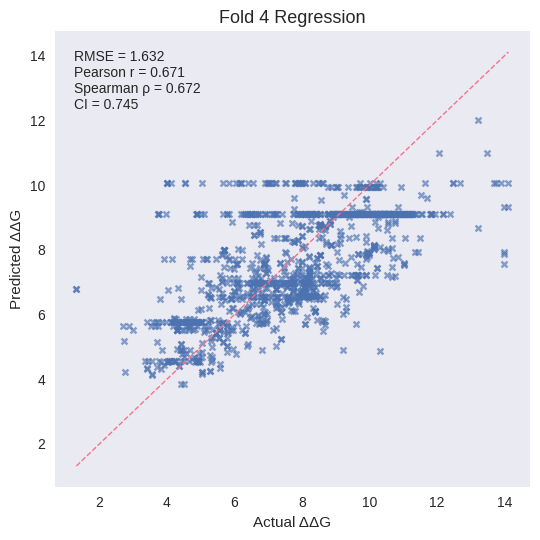

(deepchem metrics) RMSE: 1.6320, Pearson: 0.4498

===== FOLD 5/10 =====
Train samples: 10817 | Val samples: 1202


Fold 5 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.6625 | Best RMSE: inf | Patience: 0/10


Fold 5 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.6610 | Best RMSE: 1.6625 | Patience: 0/10


Fold 5 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.6607 | Best RMSE: 1.6610 | Patience: 0/10


Fold 5 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.6022 | Best RMSE: 1.6607 | Patience: 0/10


Fold 5 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.6253 | Best RMSE: 1.6022 | Patience: 0/10


Fold 5 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.6467 | Best RMSE: 1.6022 | Patience: 1/10


Fold 5 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.6170 | Best RMSE: 1.6022 | Patience: 2/10


Fold 5 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.5580 | Best RMSE: 1.6022 | Patience: 3/10


Fold 5 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.5662 | Best RMSE: 1.5580 | Patience: 0/10


Fold 5 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.6331 | Best RMSE: 1.5580 | Patience: 1/10


Fold 5 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.6789 | Best RMSE: 1.5580 | Patience: 2/10


Fold 5 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.5548 | Best RMSE: 1.5580 | Patience: 3/10


Fold 5 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.5813 | Best RMSE: 1.5548 | Patience: 0/10


Fold 5 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.5577 | Best RMSE: 1.5548 | Patience: 1/10


Fold 5 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.5505 | Best RMSE: 1.5548 | Patience: 2/10


Fold 5 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.5923 | Best RMSE: 1.5505 | Patience: 0/10


Fold 5 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.6596 | Best RMSE: 1.5505 | Patience: 1/10


Fold 5 Epoch 18/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 18 | Val RMSE: 1.5900 | Best RMSE: 1.5505 | Patience: 2/10


Fold 5 Epoch 19/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 19 | Val RMSE: 1.7192 | Best RMSE: 1.5505 | Patience: 3/10


Fold 5 Epoch 20/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 20 | Val RMSE: 1.5877 | Best RMSE: 1.5505 | Patience: 4/10


Fold 5 Epoch 21/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 21 | Val RMSE: 1.6570 | Best RMSE: 1.5505 | Patience: 5/10


Fold 5 Epoch 22/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 22 | Val RMSE: 1.6298 | Best RMSE: 1.5505 | Patience: 6/10


Fold 5 Epoch 23/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 23 | Val RMSE: 1.6414 | Best RMSE: 1.5505 | Patience: 7/10


Fold 5 Epoch 24/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 24 | Val RMSE: 1.6387 | Best RMSE: 1.5505 | Patience: 8/10


Fold 5 Epoch 25/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 25 | Val RMSE: 1.6183 | Best RMSE: 1.5505 | Patience: 9/10
⏹️ Early stopping at epoch 25
Fold 5 Metrics: RMSE=1.5505, Pearson=0.7097, Spearman=0.6619, CI=0.7401
Saved fold 5 best model to best_model_fold5.pth


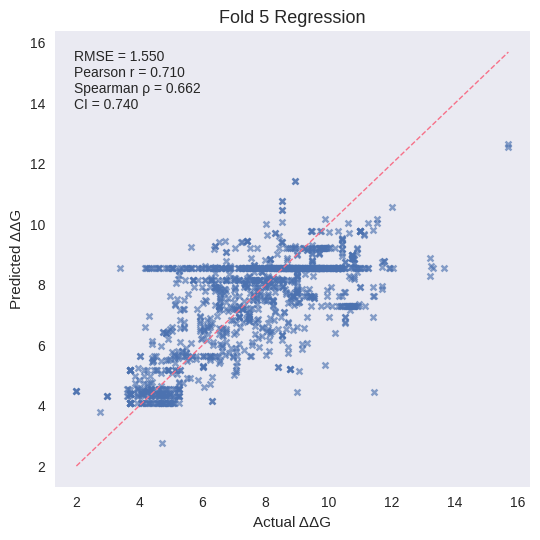

(deepchem metrics) RMSE: 1.5505, Pearson: 0.5036

===== FOLD 6/10 =====
Train samples: 10817 | Val samples: 1202


Fold 6 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.5070 | Best RMSE: inf | Patience: 0/10


Fold 6 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.6323 | Best RMSE: 1.5070 | Patience: 0/10


Fold 6 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.5382 | Best RMSE: 1.5070 | Patience: 1/10


Fold 6 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.5576 | Best RMSE: 1.5070 | Patience: 2/10


Fold 6 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.5795 | Best RMSE: 1.5070 | Patience: 3/10


Fold 6 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.5871 | Best RMSE: 1.5070 | Patience: 4/10


Fold 6 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.6549 | Best RMSE: 1.5070 | Patience: 5/10


Fold 6 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.6396 | Best RMSE: 1.5070 | Patience: 6/10


Fold 6 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.6332 | Best RMSE: 1.5070 | Patience: 7/10


Fold 6 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.6549 | Best RMSE: 1.5070 | Patience: 8/10


Fold 6 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.6562 | Best RMSE: 1.5070 | Patience: 9/10
⏹️ Early stopping at epoch 11
Fold 6 Metrics: RMSE=1.5070, Pearson=0.6488, Spearman=0.6589, CI=0.7357
Saved fold 6 best model to best_model_fold6.pth


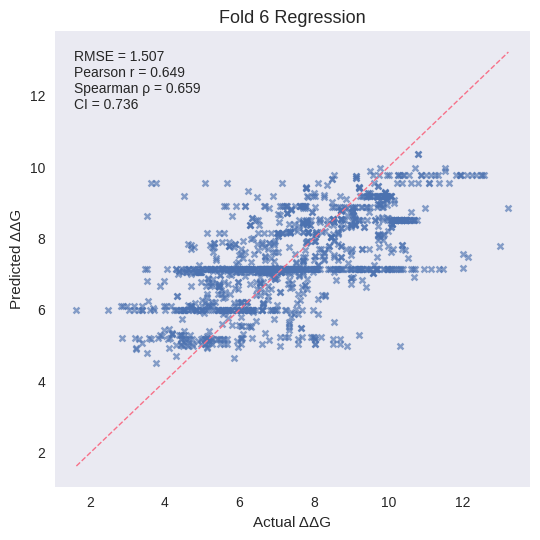

(deepchem metrics) RMSE: 1.5070, Pearson: 0.4209

===== FOLD 7/10 =====
Train samples: 10817 | Val samples: 1202


Fold 7 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.4599 | Best RMSE: inf | Patience: 0/10


Fold 7 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.6659 | Best RMSE: 1.4599 | Patience: 0/10


Fold 7 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.4000 | Best RMSE: 1.4599 | Patience: 1/10


Fold 7 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.3585 | Best RMSE: 1.4000 | Patience: 0/10


Fold 7 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.3356 | Best RMSE: 1.3585 | Patience: 0/10


Fold 7 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.3661 | Best RMSE: 1.3356 | Patience: 0/10


Fold 7 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.3507 | Best RMSE: 1.3356 | Patience: 1/10


Fold 7 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.3543 | Best RMSE: 1.3356 | Patience: 2/10


Fold 7 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.4015 | Best RMSE: 1.3356 | Patience: 3/10


Fold 7 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.4035 | Best RMSE: 1.3356 | Patience: 4/10


Fold 7 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.4049 | Best RMSE: 1.3356 | Patience: 5/10


Fold 7 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.4329 | Best RMSE: 1.3356 | Patience: 6/10


Fold 7 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.3727 | Best RMSE: 1.3356 | Patience: 7/10


Fold 7 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.5190 | Best RMSE: 1.3356 | Patience: 8/10


Fold 7 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.4014 | Best RMSE: 1.3356 | Patience: 9/10
⏹️ Early stopping at epoch 15
Fold 7 Metrics: RMSE=1.3356, Pearson=0.7620, Spearman=0.7519, CI=0.7723
Saved fold 7 best model to best_model_fold7.pth


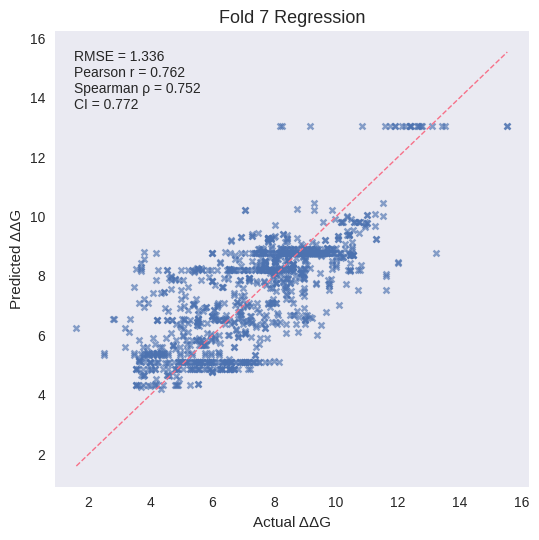

(deepchem metrics) RMSE: 1.3356, Pearson: 0.5807

===== FOLD 8/10 =====
Train samples: 10817 | Val samples: 1202


Fold 8 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.5591 | Best RMSE: inf | Patience: 0/10


Fold 8 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.6720 | Best RMSE: 1.5591 | Patience: 0/10


Fold 8 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.5437 | Best RMSE: 1.5591 | Patience: 1/10


Fold 8 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.5257 | Best RMSE: 1.5437 | Patience: 0/10


Fold 8 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.5541 | Best RMSE: 1.5257 | Patience: 0/10


Fold 8 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.4887 | Best RMSE: 1.5257 | Patience: 1/10


Fold 8 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.5380 | Best RMSE: 1.4887 | Patience: 0/10


Fold 8 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.4619 | Best RMSE: 1.4887 | Patience: 1/10


Fold 8 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.6104 | Best RMSE: 1.4619 | Patience: 0/10


Fold 8 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.4895 | Best RMSE: 1.4619 | Patience: 1/10


Fold 8 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.6341 | Best RMSE: 1.4619 | Patience: 2/10


Fold 8 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.4788 | Best RMSE: 1.4619 | Patience: 3/10


Fold 8 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.6120 | Best RMSE: 1.4619 | Patience: 4/10


Fold 8 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.4771 | Best RMSE: 1.4619 | Patience: 5/10


Fold 8 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.6140 | Best RMSE: 1.4619 | Patience: 6/10


Fold 8 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.5304 | Best RMSE: 1.4619 | Patience: 7/10


Fold 8 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.4785 | Best RMSE: 1.4619 | Patience: 8/10


Fold 8 Epoch 18/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 18 | Val RMSE: 1.5211 | Best RMSE: 1.4619 | Patience: 9/10
⏹️ Early stopping at epoch 18
Fold 8 Metrics: RMSE=1.4619, Pearson=0.6388, Spearman=0.6015, CI=0.7114
Saved fold 8 best model to best_model_fold8.pth


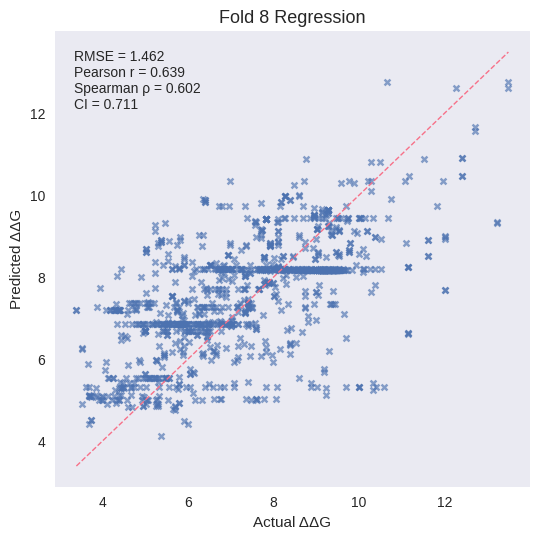

(deepchem metrics) RMSE: 1.4619, Pearson: 0.4080

===== FOLD 9/10 =====
Train samples: 10817 | Val samples: 1202


Fold 9 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 2.0150 | Best RMSE: inf | Patience: 0/10


Fold 9 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.8204 | Best RMSE: 2.0150 | Patience: 0/10


Fold 9 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.7250 | Best RMSE: 1.8204 | Patience: 0/10


Fold 9 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.7131 | Best RMSE: 1.7250 | Patience: 0/10


Fold 9 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.8606 | Best RMSE: 1.7131 | Patience: 0/10


Fold 9 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.7272 | Best RMSE: 1.7131 | Patience: 1/10


Fold 9 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.6181 | Best RMSE: 1.7131 | Patience: 2/10


Fold 9 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.6464 | Best RMSE: 1.6181 | Patience: 0/10


Fold 9 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.7903 | Best RMSE: 1.6181 | Patience: 1/10


Fold 9 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.6527 | Best RMSE: 1.6181 | Patience: 2/10


Fold 9 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.6675 | Best RMSE: 1.6181 | Patience: 3/10


Fold 9 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.6956 | Best RMSE: 1.6181 | Patience: 4/10


Fold 9 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.6234 | Best RMSE: 1.6181 | Patience: 5/10


Fold 9 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.6981 | Best RMSE: 1.6181 | Patience: 6/10


Fold 9 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.6765 | Best RMSE: 1.6181 | Patience: 7/10


Fold 9 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.6696 | Best RMSE: 1.6181 | Patience: 8/10


Fold 9 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.6011 | Best RMSE: 1.6181 | Patience: 9/10


Fold 9 Epoch 18/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 18 | Val RMSE: 1.6212 | Best RMSE: 1.6011 | Patience: 0/10


Fold 9 Epoch 19/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 19 | Val RMSE: 1.7390 | Best RMSE: 1.6011 | Patience: 1/10


Fold 9 Epoch 20/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 20 | Val RMSE: 1.6692 | Best RMSE: 1.6011 | Patience: 2/10


Fold 9 Epoch 21/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 21 | Val RMSE: 1.7113 | Best RMSE: 1.6011 | Patience: 3/10


Fold 9 Epoch 22/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 22 | Val RMSE: 1.6599 | Best RMSE: 1.6011 | Patience: 4/10


Fold 9 Epoch 23/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 23 | Val RMSE: 1.7049 | Best RMSE: 1.6011 | Patience: 5/10


Fold 9 Epoch 24/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 24 | Val RMSE: 1.6956 | Best RMSE: 1.6011 | Patience: 6/10


Fold 9 Epoch 25/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 25 | Val RMSE: 1.6922 | Best RMSE: 1.6011 | Patience: 7/10


Fold 9 Epoch 26/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 26 | Val RMSE: 1.6410 | Best RMSE: 1.6011 | Patience: 8/10


Fold 9 Epoch 27/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 27 | Val RMSE: 1.6860 | Best RMSE: 1.6011 | Patience: 9/10
⏹️ Early stopping at epoch 27
Fold 9 Metrics: RMSE=1.6011, Pearson=0.7391, Spearman=0.6672, CI=0.7450
Saved fold 9 best model to best_model_fold9.pth


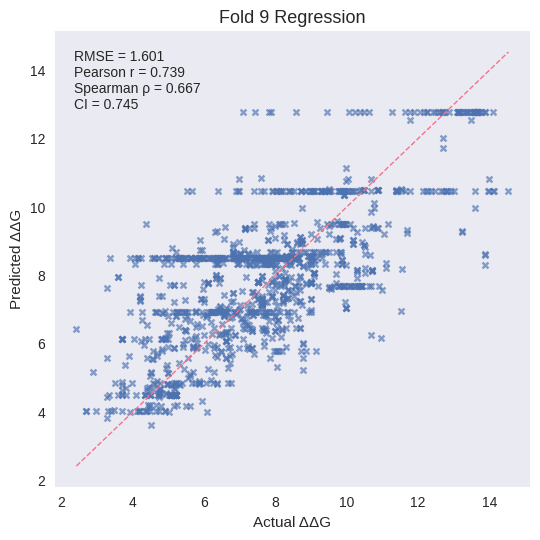

(deepchem metrics) RMSE: 1.6011, Pearson: 0.5463

===== FOLD 10/10 =====
Train samples: 10818 | Val samples: 1201


Fold 10 Epoch 1/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 1 | Val RMSE: 1.6876 | Best RMSE: inf | Patience: 0/10


Fold 10 Epoch 2/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 2 | Val RMSE: 1.5563 | Best RMSE: 1.6876 | Patience: 0/10


Fold 10 Epoch 3/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 3 | Val RMSE: 1.7291 | Best RMSE: 1.5563 | Patience: 0/10


Fold 10 Epoch 4/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 4 | Val RMSE: 1.5762 | Best RMSE: 1.5563 | Patience: 1/10


Fold 10 Epoch 5/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 5 | Val RMSE: 1.5299 | Best RMSE: 1.5563 | Patience: 2/10


Fold 10 Epoch 6/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 6 | Val RMSE: 1.5543 | Best RMSE: 1.5299 | Patience: 0/10


Fold 10 Epoch 7/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 7 | Val RMSE: 1.5534 | Best RMSE: 1.5299 | Patience: 1/10


Fold 10 Epoch 8/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 8 | Val RMSE: 1.5225 | Best RMSE: 1.5299 | Patience: 2/10


Fold 10 Epoch 9/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 9 | Val RMSE: 1.4940 | Best RMSE: 1.5225 | Patience: 0/10


Fold 10 Epoch 10/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 10 | Val RMSE: 1.6170 | Best RMSE: 1.4940 | Patience: 0/10


Fold 10 Epoch 11/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 11 | Val RMSE: 1.5117 | Best RMSE: 1.4940 | Patience: 1/10


Fold 10 Epoch 12/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 12 | Val RMSE: 1.4754 | Best RMSE: 1.4940 | Patience: 2/10


Fold 10 Epoch 13/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 13 | Val RMSE: 1.5137 | Best RMSE: 1.4754 | Patience: 0/10


Fold 10 Epoch 14/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 14 | Val RMSE: 1.5556 | Best RMSE: 1.4754 | Patience: 1/10


Fold 10 Epoch 15/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 15 | Val RMSE: 1.5903 | Best RMSE: 1.4754 | Patience: 2/10


Fold 10 Epoch 16/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 16 | Val RMSE: 1.5521 | Best RMSE: 1.4754 | Patience: 3/10


Fold 10 Epoch 17/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 17 | Val RMSE: 1.5457 | Best RMSE: 1.4754 | Patience: 4/10


Fold 10 Epoch 18/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 18 | Val RMSE: 1.5388 | Best RMSE: 1.4754 | Patience: 5/10


Fold 10 Epoch 19/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 19 | Val RMSE: 1.5573 | Best RMSE: 1.4754 | Patience: 6/10


Fold 10 Epoch 20/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 20 | Val RMSE: 1.5555 | Best RMSE: 1.4754 | Patience: 7/10


Fold 10 Epoch 21/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 21 | Val RMSE: 1.5839 | Best RMSE: 1.4754 | Patience: 8/10


Fold 10 Epoch 22/100:   0%|          | 0/1353 [00:00<?, ?it/s]

Epoch 22 | Val RMSE: 1.5633 | Best RMSE: 1.4754 | Patience: 9/10
⏹️ Early stopping at epoch 22
Fold 10 Metrics: RMSE=1.4754, Pearson=0.7704, Spearman=0.6635, CI=0.7445
Saved fold 10 best model to best_model_fold10.pth


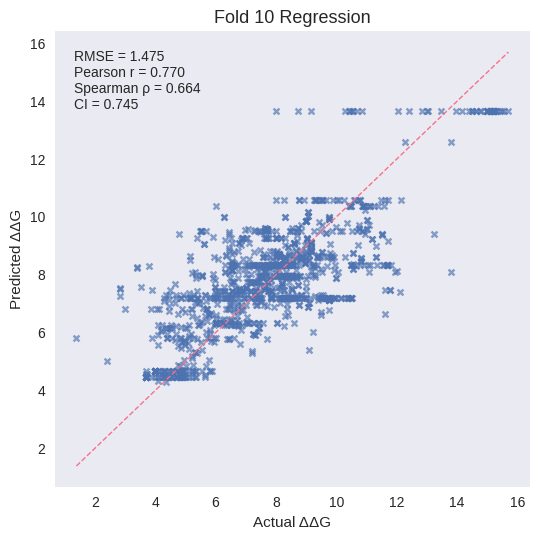

(deepchem metrics) RMSE: 1.4754, Pearson: 0.5935


In [15]:
print("\n" + "="*80)
print("... 7. STARTING GROUPK-FOLD CROSS-VALIDATION ...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

all_fold_results = []
aggregate_y_true = []
aggregate_y_pred = []

splits = list(get_group_splits(df, N_SPLITS))
print(f"Prepared {len(splits)} folds.")

for fold_idx, (train_idx, val_idx) in enumerate(splits):
    fold_num = fold_idx + 1
    print(f"\n===== FOLD {fold_num}/{len(splits)} =====")
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)
    print(f"Train samples: {len(train_df)} | Val samples: {len(val_df)}")

    train_dataset = PPIDataset(train_df, EMBEDDING_CACHE)
    val_dataset = PPIDataset(val_df, EMBEDDING_CACHE)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_ppi)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_ppi)

    model = PPiAttentionModel(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, dropout=DROPOUT).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    best_rmse = float("inf")
    best_state = None
    patience = 0

    for epoch in range(EPOCHS):
        model.train()
        train_losses = []
        pbar = tqdm(train_loader, desc=f"Fold {fold_num} Epoch {epoch+1}/{EPOCHS}", leave=False)
        for batch in pbar:
            optimizer.zero_grad()
            seqA_emb = batch["seqA_emb"].to(device)
            seqA_mask = batch["seqA_mask"].to(device)
            seqB_emb = batch["seqB_emb"].to(device)
            seqB_mask = batch["seqB_mask"].to(device)
            y = batch["y"].to(device)

            preds, _ = model(seqA_emb, seqA_mask, seqB_emb, seqB_mask)
            loss = F.mse_loss(preds, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            pbar.set_postfix({"train_loss": np.mean(train_losses)})

        # validation
        val_metrics, y_true, y_pred = evaluate_model_simple(model, val_loader, device)
        current_rmse = val_metrics["rmse"] if val_metrics["rmse"] == val_metrics["rmse"] else float("inf")
        print(f"Epoch {epoch+1} | Val RMSE: {current_rmse:.4f} | Best RMSE: {best_rmse:.4f} | Patience: {patience}/{EARLY_STOPPING_PATIENCE}")

        if (best_rmse - current_rmse) > EARLY_STOPPING_MIN_DELTA:
            best_rmse = current_rmse
            best_state = deepcopy(model.state_dict())
            patience = 0
        else:
            patience += 1
            if patience >= EARLY_STOPPING_PATIENCE:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    # restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    # final evaluation for fold
    fold_metrics, y_true, y_pred = evaluate_model_simple(model, val_loader, device)
    print(f"Fold {fold_num} Metrics: RMSE={fold_metrics['rmse']:.4f}, Pearson={fold_metrics['pearson']:.4f}, Spearman={fold_metrics['spearman']:.4f}, CI={fold_metrics['ci']:.4f}")
    all_fold_results.append(fold_metrics)

    # save best model for this fold
    fold_model_path = f"best_model_fold{fold_num}.pth"
    torch.save(model.state_dict(), fold_model_path)
    print(f"Saved fold {fold_num} best model to {fold_model_path}")

    # aggregate predictions for overall plot
    if len(y_true) > 0:
        aggregate_y_true.extend(y_true.tolist())
        aggregate_y_pred.extend(y_pred.tolist())

        plot_regression(y_true, y_pred, fold_metrics, title=f"Fold {fold_num} Regression")

        # ensure numpy arrays in shape (N, 1) and numeric dtype
        y_true_arr = np.array(y_true, dtype=np.float32).reshape(-1, 1)
        y_pred_arr = np.array(y_pred, dtype=np.float32).reshape(-1, 1)

        # Optional: small DeepChem dataset for bookkeeping (X unused here)
        fold_X = np.arange(len(y_true_arr))[:, None]
        fold_y = y_true_arr
        _ = dc.data.NumpyDataset(fold_X, fold_y)  # assigned to _ to avoid unused var warning

        # Compute DeepChem metrics (functions expect shape (N, n_tasks))
        try:
            mse_dc = dc.metrics.mean_squared_error(fold_y, y_pred_arr)
            mse_val = float(np.array(mse_dc).item())
            rmse_dc = np.sqrt(mse_val)
        except Exception as e:
            print(f"⚠️ deepchem.mean_squared_error failed: {e}")
            rmse_dc = np.nan

        try:
            pearson_dc = dc.metrics.pearson_r2_score(fold_y, y_pred_arr)
            pearson_dc = float(np.array(pearson_dc).item())
        except Exception as e:
            print(f"⚠️ deepchem.pearson_r2_score failed: {e}")
            pearson_dc = np.nan

        print(f"(deepchem metrics) RMSE: {rmse_dc:.4f}, Pearson: {pearson_dc:.4f}")

##Final results comparison

This final cell aggregates fold-level results and plots the overall regression.


... 8. FINAL CROSS-VALIDATION RESULTS COMPARISON ...
Per-fold summary (mean ± std):
              mean       std
rmse      1.506549  0.108957
pearson   0.701164  0.062959
spearman  0.670291  0.048378
ci        0.742480  0.021263

Overall aggregated metrics:
{'rmse': np.float64(1.510093590747584), 'pearson': np.float64(0.7124963110163669), 'spearman': np.float64(0.6953771194559649), 'ci': 0.75494636351212}


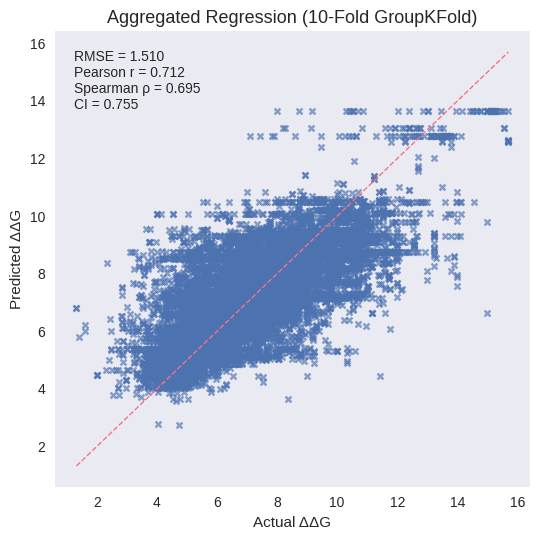


✅ Benchmark analysis complete.


In [16]:
print("\n" + "="*80)
print("... 8. FINAL CROSS-VALIDATION RESULTS COMPARISON ...")

if all_fold_results:
    results_df = pd.DataFrame(all_fold_results)
    summary = pd.DataFrame({"mean": results_df.mean(), "std": results_df.std()})
    print("Per-fold summary (mean ± std):")
    print(summary)
else:
    print("⚠️ No fold results to summarize.")

# overall aggregated metrics
if aggregate_y_true and aggregate_y_pred:
    agg_true = np.array(aggregate_y_true)
    agg_pred = np.array(aggregate_y_pred)
    overall_metrics = {
        "rmse": np.sqrt(mean_squared_error(agg_true, agg_pred)),
        "pearson": pearsonr(agg_true, agg_pred)[0],
        "spearman": spearmanr(agg_true, agg_pred)[0],
        "ci": concordance_index(agg_true, agg_pred)
    }
    print("\nOverall aggregated metrics:")
    print(overall_metrics)
    plot_regression(agg_true, agg_pred, overall_metrics, title=f"Aggregated Regression ({N_SPLITS}-Fold GroupKFold)")
else:
    print("⚠️ Not enough aggregated predictions to compute overall metrics.")

print("\n✅ Benchmark analysis complete.")

## Conclusion and Results

The model achieves a **Pearson Correlation ($R$) of ~0.71** and a **Concordance Index (CI) of ~0.75** on the held-out validation folds.

This performance is competitive with state-of-the-art structure-based predictors, despite using only sequence information. This demonstrates the power of combining:
1.  **Pretrained PLMs** (ESM-2) for robust features.
2.  **Attention Mechanisms** for selecting relevant residues.
3.  **DeepChem** for rigorous splitting and metric tracking.

This pipeline can be extended by using larger ESM models or by fine-tuning the last few layers of the encoder.